# Ъуъ (U)

In [ ]:
!pip install catboost
!pip install fastparquet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 61.0 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import tqdm
from typing import List

%load_ext autoreload
%autoreload 2

import gc
import os
import sys
import pandas as pd
import numpy as np
import tqdm
import seaborn as sns


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score

import catboost as cb
import lightgbm as lgb

pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Загрузка данных

In [ ]:
data_frame = pd.read_parquet('train_ai_comp_final_dp.parquet', engine="fastparquet")

In [ ]:
data_frame

id  target  sample_ml_new  feature1  feature2  feature3  feature4  \
0            0       0              1      1761      1759        85    105469   
1            1       0              1      1761      1759       120    105610   
2            2       0              1       890      1759       141    105227   
5            5       0              1      1599       966        30    102441   
6            6       0              1      1761      1759        85    104006   
...        ...     ...            ...       ...       ...       ...       ...   
693036  693036       0              1      1761      1759       141       410   
693038  693038       0              1      1761      1759         0       170   
693039  693039       0              1      1761      1759         0       168   
693040  693040       0              1      1761      1759       141        74   
693042  693042       1              1      1761      1759       141        28   

        feature5  feature6  feature7  feature8  feature9  feature10  \
0            191        46         0         6        95          0   
1            144        71         0       135       135          0   
2            191        11         0         0         0          0   
5            191         8         0         0         0          0   
6            191         2         0         0        46          0   
...          ...       ...       ...       ...       ...        ...   
693036       191         2       125       290       298        176   
693038       191         1       125       290       298        176   
693039       191         1       125       290       298        176   
693040       191         1       125       290       298        176   
693042       191         0       125       290       298        176   

        feature11  feature12  feature13  feature14  feature15  feature16  \
0               0         20        191          1          6         50   
1               0        187        144          1        135         43   
2               0        187        191          1          0          0   
5               0        187        191          1          0          0   
6               0          2        191          1          0          1   
...           ...        ...        ...        ...        ...        ...   
693036        121        187        191        227        282        243   
693038        121        187        191        227        282        243   
693039        121        187        191        227        282        243   
693040        121        187        191        227        282        243   
693042        121        187        191        227        282        243   

        feature17  feature18  feature19  feature20  feature21  feature22  \
0              60          7        248        248        347      91601   
1             101         11         18         18         58      36890   
2               0         28        248        248        347     140184   
5               0         28        248        248        347     140184   
6              21          3        248        248        347     140184   
...           ...        ...        ...        ...        ...        ...   
693036        275         28        248        248        347     140184   
693038        275         28        248        248        347     140184   
693039        275         28        248        248        347     140184   
693040        275         28        248        248        347     140184   
693042        275         28        248        248        347     140184   

        feature23  feature24  feature25  feature26  feature27  feature28  \
0               9        173       1722          5          8          9   
1               9        184       1722          5          8          9   
2               9        248       1722          5          8          9   
5               9        248       1722          5      

In [ ]:
data_frame = data_frame.drop(['id', 'sample_ml_new'], axis=1)

## Отбор признаков по корреляции

In [ ]:
corr_df = pd.DataFrame(columns=['feature', 'corr_value'])
target_column = 'target'
collumn_names = data_frame.columns.drop(target_column)

for feature in collumn_names:
    corr_matrix = data_frame[[target_column, feature]].corr()
    corr_value = corr_matrix.loc[target_column, feature]
    corr_df = pd.concat(
        [corr_df, pd.DataFrame([[feature, corr_value]], columns=corr_df.columns)],
        ignore_index=True)

In [ ]:
corr_df = corr_df.sort_values(by='corr_value', key=abs, ascending=False)[:200]
valuable_features = corr_df['feature'].values.tolist()
valuable_features += [target_column]
data_frame = data_frame[valuable_features]

## Подбор и обучение модели

In [ ]:
# Standard python libraries
import os
import time
import requests

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import torch

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


/home/user/.local/lib/python3.10/site-packages/lightautoml/ml_algo/dl_model.py:42: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")
/home/user/.local/lib/python3.10/site-packages/lightautoml/text/embed.py:22: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")
/home/user/.local/lib/python3.10/site-packages/lightautoml/text/dl_transformers.py:25: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")


In [ ]:
N_THREADS = 10
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 10*3600
TARGET_NAME = 'target'

In [ ]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [ ]:
task = Task('binary')

roles = {
    'target': TARGET_NAME
}

In [ ]:
automl = TabularUtilizedAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    tuning_params = {'max_tuning_time': 900},
    reader_params = {'n_jobs': N_THREADS}
)

In [ ]:
%%time
oof_pred = automl.fit_predict(data_frame, roles = roles, verbose = 1)

In [ ]:
print(automl.create_model_str_desc())

## Метрики

In [ ]:
print(f'OOF score: {roc_auc_score(data_frame[TARGET_NAME].values, oof_pred.data[:, 0])}')

OOF score: 0.7637374221997356


In [ ]:
pred = np.where(oof_pred.data[:, 0] < 0.1, 0, 1)

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
print(classification_report(data_frame[TARGET_NAME].values, pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96    501078
           1       0.17      0.27      0.21     18537

    accuracy                           0.93    519615
   macro avg       0.57      0.61      0.59    519615
weighted avg       0.94      0.93      0.93    519615



In [ ]:
print(roc_auc_score(data_frame[TARGET_NAME].values, pred))

0.6124413119255652


In [ ]:
print(f1_score(data_frame[TARGET_NAME].values, pred, average = 'weighted', labels = np.unique(pred)))

0.9347112109928554


In [ ]:
print(precision_score(data_frame[TARGET_NAME].values, pred, average = 'weighted', labels = np.unique(pred)))

0.9439272296143473


In [ ]:
print(recall_score(data_frame[TARGET_NAME].values, pred, average = 'weighted', labels = np.unique(pred)))

0.9265918035468568


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(data_frame[TARGET_NAME].values, pred)

<Axes: >

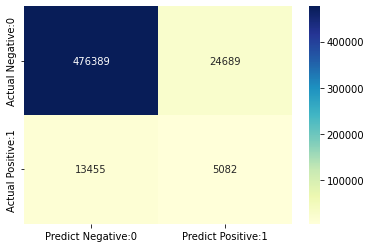

In [ ]:
cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0', 'Predict Positive:1'],
                                 index=['Actual Negative:0', 'Actual Positive:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

## Сохранение модели

In [ ]:
import joblib

In [ ]:
joblib.dump(automl, 'model.pkl')

['model.pkl']